In [24]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:

from utils_emb import *

In [25]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
ge_df = pd.read_csv("/var/www/datasets/ex15noNormMerged.csv.xz", index_col="patient_ID")


In [26]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]
ge_out_df = ge_df.join(st_df["posOutcome"])
ge_tamx_df = ge_df.loc[st_tamx_df.index,:]
ge_out_tamx_df = ge_tamx_df.join(st_df["posOutcome"])

In [27]:
gse17705_idx = st_tamx_df[st_tamx_df["series_id"] == "GSE17705"].index
X_17705, y_17705 = ge_tamx_df.loc[gse17705_idx], ge_out_tamx_df["posOutcome"].loc[gse17705_idx]
print(X_17705.shape)

(298, 8832)


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_17705_sc = scaler.fit_transform(X_17705)
X_17705_sc = pd.DataFrame(X_17705_sc, index=X_17705.index, columns=X_17705.columns)

In [133]:
X_17705_fc =  X_17705.loc[:,X_17705.mean() > 5]

In [88]:
import diffxpy.api as de
import anndata

data = anndata.AnnData(
    X=X_17705.values,
    var=pd.DataFrame(index=X_17705.columns.to_list()),
    obs=y_17705.to_frame()
)

data_t_fc = anndata.AnnData(
    X=X_17705_fc.values,
    var=pd.DataFrame(index=X_17705_fc.columns.to_list()),
    obs=y_17705.to_frame()
)

test_t_fc = de.test.t_test(
    data=data_t_fc,
    grouping="posOutcome",
    is_logged=True
)
test_t = de.test.t_test(
    data=data,
    grouping="posOutcome",
    is_logged=True
)

/home/xabush/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


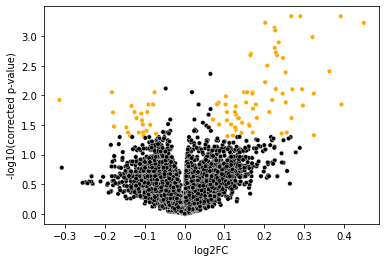

In [30]:
test_t.plot_volcano(min_fc=1.05, alpha=0.05, size=20)

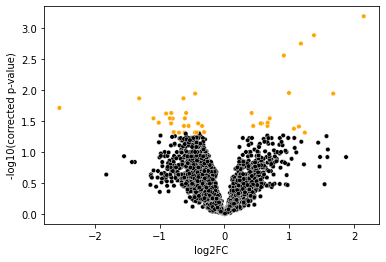

In [89]:
test_t_fc.plot_volcano(min_fc=1.05, alpha=0.05, size=20)


In [70]:
test_t_df = test_t.summary(qval_thres=0.05)
log_pos_genes = test_t_df[test_t_df["log2fc"] > 0]["gene"].to_list()
log_neg_genes = test_t_df[test_t_df["log2fc"] < 0]["gene"].to_list()

In [58]:
#Verify that positive log2fc means over-expression in control
case_idx = y_17705[y_17705 == 0].index
ctr_idx = y_17705[y_17705 == 1].index
genes_1 = []
for g in log_pos_genes:
    med = X_17705[g].median()
    mean_0 = X_17705.loc[case_idx][g].mean()
    mean_1 = X_17705.loc[ctr_idx][g].mean()
    if mean_1 > mean_0:
        genes_1.append(g)
    else:
        print("Gene {0} has higher mean_0({1}) than mean_1({2})".format(g, mean_0, mean_1))
print(len(genes_1) == len(log_pos_genes))

True


In [59]:
#Verify that negative log2fc means over-expression in control
genes_2 = []
for g in log_neg_genes:
    med = X_17705[g].median()
    mean_0 = X_17705.loc[case_idx][g].mean()
    mean_1 = X_17705.loc[ctr_idx][g].mean()
    if mean_1 < mean_0:
        genes_2.append(g)
    else:
        print("Gene {0} has higher mean_1({1}) than mean_0({2})".format(g, mean_1, mean_0))

print(len(genes_2) == len(log_neg_genes))


True


In [111]:
feat_diff_exp = test_t.summary(qval_thres=0.05).sort_values(by="log2fc")["gene"].to_list()
len(feat_diff_exp)

108

In [127]:
pop_genes = X_17705.columns.to_list()
# pop_genes = [x for x in X_17705.columns.to_list() if x not in feat_diff_exp]
len(pop_genes)

8832

In [61]:
from convert_symbol_to_entrez import convert_symbol_to_geneid, read_symbol2geneid

sym2geneid = read_symbol2geneid("datasets/Homo_sapiens.gene_info")

  126,696 READ: datasets/Homo_sapiens.gene_info


In [128]:
feat_diff_exp_ids = convert_symbol_to_geneid(feat_diff_exp, sym2geneid)
feats_all_ids = convert_symbol_to_geneid(pop_genes, sym2geneid)

In [129]:
with open("datasets/feat_all_ids.txt", "w") as fp:
    print_array(feats_all_ids, fp)

with open("datasets/feat_diff_exp_gse17705_id.txt", "w") as fp:
    print_array(feat_diff_exp_ids, fp)

In [132]:
print_array(feat_diff_exp[:20])

S100P
SQLE
HSP90B1
POLR2K
MB
ATP6V1C1
UBE2W
TXN
MRPL13
TIMM17A
UBE2C
CACYBP
SYNJ2
ZDHHC13
MARS
PLA2G12A
IMPAD1
RACGAP1
UBE2A
SAR1A


In [124]:
from goatools.cli.find_enrichment import GoeaCliFnc
import collections as cx
opt = {
    'annofmt': None,
    'alpha' : 0.05,
    'compare' : False,
    'filenames' : ['datasets/feat_diff_exp_gse17705_id.txt',
                    'datasets/feat_all_ids.txt', 'gene2go'],
    'goslim' : 'datasets/goslim_generic.obo',
    'indent' : False,
    'method' : 'bonferroni,sidak,holm,fdr_bh',
    'min_overlap' : 0.7,
    'no_propagate_counts' : False,
    'obo' : 'datasets/go-basic.obo',
    'outfile' : 'datasets/goea_gse17705.txt',
    'outfile_detail' : None,
    'ns': 'BP',
    'pval' : 0.05,
    'pval_field' : 'uncorrected',
    'pvalcalc' : 'fisher',
    'ratio' : None,
    'relationship': False,
    'relationships': None,
    'sections' : None,
    'ev_inc': None,
    'ev_exc': None,
    'taxid': 9606
    # BROAD 'remove_goids': None,
}
args = cx.namedtuple("Namespace", " ".join(opt.keys()))
args = args(**opt)

In [130]:
goea = GoeaCliFnc(args)
res = goea.get_results_sig()

goea.prt_outfiles_flat(res, ['datasets/goea_gse17705_bp.tsv'])

datasets/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 GO Terms
HMS:0:00:03.859283 157,312 annotations, 18,870 genes, 12,354 GOs, 1 taxids READ: gene2go BP
Study: 108 vs. Population 8822


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 96%  8,450 of  8,822 population items found in association

Run BP Gene Ontology Analysis: current study set of 108 IDs ... 98%    106 of    108 study items found in association
100%    108 of    108 study items found in population(8822)
Calculating 14,105 uncorrected p-values using fisher_scipy_stats
  14,105 GO terms are associated with  8,450 of  8,822 population items
   2,758 GO terms are associated with    106 of    108 study items
  METHOD bonferroni:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signi

In [125]:
goea_df = pd.read_table('datasets/goea_gse17705_bp.tsv')
display(goea_df)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:1901998,BP,e,toxin transport,3/40,16/4109,0.000439,4,3,1.0,1.0,1.0,1.0,"7203, 22948, 23256"
1,GO:0050433,BP,e,regulation of catecholamine secretion,2/40,4/4109,0.000548,8,2,1.0,1.0,1.0,1.0,"150, 6387"
2,GO:0048251,BP,e,elastic fiber assembly,2/40,5/4109,0.000907,7,2,1.0,1.0,1.0,1.0,"4629, 10516"
3,GO:0031668,BP,e,cellular response to extracellular stimulus,5/40,81/4109,0.001007,4,5,1.0,1.0,1.0,1.0,"355, 2353, 4141, 6422, 51022"
4,GO:1904851,BP,e,positive regulation of establishment of protei...,2/40,7/4109,0.001882,8,2,1.0,1.0,1.0,1.0,"7203, 22948"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,GO:0051044,BP,e,positive regulation of membrane protein ectodo...,1/40,5/4109,0.047758,9,1,1.0,1.0,1.0,1.0,150
317,GO:0002761,BP,e,regulation of myeloid leukocyte differentiation,2/40,37/4109,0.049678,7,2,1.0,1.0,1.0,1.0,"2353, 6422"
318,GO:0001505,BP,e,regulation of neurotransmitter levels,2/40,37/4109,0.049678,3,2,1.0,1.0,1.0,1.0,"18, 150"
319,GO:0009636,BP,e,response to toxic substance,2/40,37/4109,0.049678,3,2,1.0,1.0,1.0,1.0,"2353, 23256"


In [42]:
X_diff_17705 = X_17705[feat_diff_exp]
X_diff_17705

,S100P,SQLE,HSP90B1,UBE2W,ZDHHC13,ZNF623,MB,ATP6V1C1,TXN,POLR2K,...,CNN1,ALDH1A3,MET,CXCL2,EGFR,DLX2,DST,SFRP1,GABRP,NTRK2
patient_ID,,,,,,,,,,,,,,,,,,,,,
441624,9.966949,5.498013,5.111376,3.472438,3.371401,3.258115,6.339494,5.827917,5.487497,6.323561,...,6.039507,5.467859,7.214003,7.760267,7.532238,2.274170,7.370201,9.096631,6.025702,6.269629
441625,10.181896,5.889279,4.336529,3.575469,3.407451,3.311669,6.048072,5.365804,5.877670,6.440701,...,7.855900,6.746064,6.522062,7.115059,7.844186,6.565294,9.741134,11.224571,8.302103,8.433292
441626,6.940332,4.486279,3.833436,3.437018,3.862340,2.845716,6.966459,5.634176,4.454379,6.651860,...,6.599153,6.285171,7.236982,6.860181,7.327910,2.274076,8.007302,9.678234,7.416186,7.825427
441627,6.963000,6.112628,5.144084,3.500703,3.406562,2.818226,5.934289,6.027811,5.505724,6.910070,...,3.047528,4.429600,5.103916,2.548469,3.508199,5.146108,2.476123,4.863468,2.453331,2.863053
441628,11.511024,7.468628,5.143364,5.423799,7.923753,3.906978,7.769461,6.986054,5.968653,8.396867,...,3.193345,3.605588,7.066363,2.479438,2.651576,2.274170,2.408272,3.183637,2.529123,2.707939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441917,5.175471,6.871392,6.039171,4.988831,4.155045,3.400645,8.329694,5.812699,7.601197,8.624320,...,2.437114,3.222372,2.385178,3.327213,2.333389,2.234036,5.618212,6.209763,5.815814,2.687942
441918,5.067664,6.695299,6.225024,5.187562,4.282158,3.205111,6.365523,6.589254,6.525020,8.504253,...,2.437114,2.351819,2.973944,3.214388,2.989049,6.356968,3.759652,5.145362,2.451507,2.698424
441919,2.600725,8.970731,7.297528,5.489334,4.808701,4.073177,7.154181,7.257950,7.407997,9.394895,...,2.437114,2.362438,2.323571,4.033986,2.380876,2.234036,2.620366,3.557174,2.456055,2.516098


In [296]:
from utils_emb import generate_over_under_expr

X_diff_17705_q = generate_over_under_expr(X_17705, test_t_df, y_17705)
X_diff_17705_q

,MFAP4_overexpr,HOXA5_overexpr,CLDN8_overexpr,ZNF423_overexpr,PSTPIP2_overexpr,FBLN5_overexpr,ALDH1A3_overexpr,RBBP8_overexpr,IGFBP6_overexpr,CNN1_overexpr,...,SFRP1_underexpr,SLC24A1_underexpr,SLCO4A1_underexpr,SMARCA2_underexpr,SMPDL3B_underexpr,SNX1_underexpr,SSTR3_underexpr,STRA6_underexpr,TAF6L_underexpr,ZNF167_underexpr
patient_ID,,,,,,,,,,,,,,,,,,,,,
441624,5.828606,5.532753,2.459313,7.685804,3.005754,7.419962,5.467859,7.408624,6.861792,6.039507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441625,5.044193,6.462280,5.254662,5.678823,3.085063,7.276835,6.746064,8.951831,6.134949,7.855900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441626,7.713787,6.124657,5.330896,6.755469,3.094892,8.989596,6.285171,7.684218,6.157381,6.599153,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.863468,4.910029,2.274076,5.598910,3.052735,5.312672,2.306828,2.454973,2.373965,2.316877
441628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.183637,4.758846,2.274076,5.099615,2.329014,5.821394,2.306828,2.454973,2.373965,2.319426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441917,2.233356,2.750349,2.233356,4.366278,3.148601,4.734386,3.222372,8.806633,4.385346,2.437114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441918,3.745843,2.979070,2.233356,7.904984,2.520329,5.470797,2.351819,7.263786,4.633560,2.437114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441919,2.233356,2.748988,2.233356,4.327355,3.596801,5.388685,2.362438,7.363352,3.714260,2.437114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [297]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_diff_17705_sc = scaler.fit_transform(X_diff_17705_q)
X_diff_17705_sc = pd.DataFrame(data=X_diff_17705_sc, index=X_diff_17705_q.index, columns=X_diff_17705_q.columns)
X_diff_17705_sc

,MFAP4_overexpr,HOXA5_overexpr,CLDN8_overexpr,ZNF423_overexpr,PSTPIP2_overexpr,FBLN5_overexpr,ALDH1A3_overexpr,RBBP8_overexpr,IGFBP6_overexpr,CNN1_overexpr,...,SFRP1_underexpr,SLC24A1_underexpr,SLCO4A1_underexpr,SMARCA2_underexpr,SMPDL3B_underexpr,SNX1_underexpr,SSTR3_underexpr,STRA6_underexpr,TAF6L_underexpr,ZNF167_underexpr
patient_ID,,,,,,,,,,,,,,,,,,,,,
441624,0.694432,0.585990,0.259790,0.972273,0.634840,0.825394,0.692210,0.633467,0.817170,0.762721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441625,0.600975,0.684439,0.555077,0.718385,0.651591,0.809473,0.854026,0.765418,0.730610,0.992111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441626,0.919036,0.648681,0.563130,0.854584,0.653667,1.000000,0.795679,0.657032,0.733282,0.833398,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.413819,0.923474,0.937880,0.692117,1.000000,0.705453,0.908218,0.885559,0.930228,0.712820
441628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.270887,0.895039,0.937880,0.630396,0.762927,0.773005,0.908218,0.885559,0.930228,0.713604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441917,0.266086,0.291298,0.235921,0.552345,0.665011,0.526652,0.407940,0.753003,0.522250,0.307780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441918,0.446287,0.315522,0.235921,1.000000,0.532314,0.608570,0.297731,0.621083,0.551810,0.307780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
441919,0.266086,0.291154,0.235921,0.547421,0.759674,0.599436,0.299076,0.629597,0.442331,0.307780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [303]:
X_diff_17705_sc.to_csv("datasets/pln_exp_17705/gse17705_ge.csv", index=True)

In [302]:
from utils_emb import print_array
with open("datasets/pln_exp_17705/patient_ids.txt", "w") as fp:
    print_array(list(X_diff_17705_sc.index), fp)

with open("datasets/pln_exp_17705/genes.txt", "w") as fp:
    print_array(X_diff_17705_sc.columns.to_list(), fp)

In [44]:
sample_ppt = pd.read_table("/home/xabush/morphism/bioas_analysis/pln_exp_17705/property_vector_beforekpca_p=1,T=2_notnormalized_2021-04-19_p2.csv", index_col="patient_ID")

In [106]:
go_cats = goea_df["# GO"].to_list()
go_paths = sample_ppt.columns.to_list()
overlap = find_overlap(go_cats, go_paths)

3992
321


In [49]:
with  open("datasets/pln_exp_17705/goea_gse17705_terms.txt", "w") as fp:
    print_array(go_cats, fp)

go_lst = [x for x in go_paths if "GO:" in x]
go_lst = [x.split("_")[0] for x in go_lst]

with  open("datasets/pln_exp_17705/pln_go_gse17705.txt", "w") as fp:
    print_array(go_lst, fp)

In [ ]:
comp_df = pd.read_excel("datasets/go_lists/goea_pln_gse17705_filtered.xlsx")

In [134]:
import gseapy

gseapy.enrichr(gene_list=feat_diff_exp, description="BP", gene_sets="GO_Biological_Process_2015", outdir="datasets/gseapy17705", cutoff=0.05, organism="Human")
gsea_go_bp = pd.read_table("datasets/gseapy17705/GO_Biological_Process_2015.Human.enrichr.reports.txt")
gsea_go_bp[gsea_go_bp["Adjusted P-value"] <= 0.05]

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: BP, Enrichr Library: GO_Biological_Process_2015
INFO:gseapy:Save file of enrichment results: Job Id:f8d026eb477000c8fbcd0157d84cef4b
INFO:gseapy:Done.



In [137]:
gseapy.enrichr(gene_list=feat_diff_exp, description="pathway", gene_sets="Reactome_2013", outdir="datasets/gseapy17705", cutoff=0.05, organism="Human")
gsea_reactome = pd.read_table("datasets/gseapy17705/Reactome_2013.Human.enrichr.reports.txt")
gsea_reactome[gsea_reactome["Adjusted P-value"] <= 0.05]

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: pathway, Enrichr Library: Reactome_2013
INFO:gseapy:Save file of enrichment results: Job Id:41e74db94318cedc5d125f4a6d05807f
INFO:gseapy:Done.



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2013,Regulatory RNA pathways,2/15,0.002897,0.047175,0,0,28.851959,168.608785,POLR2H;POLR2K
1,Reactome_2013,Metablism of nucleotides,3/75,0.007801,0.047175,0,0,7.865079,38.172765,ATP5I;TXN;AK5
2,Reactome_2013,Tat-mediated HIV-1 elongation arrest and recov...,2/29,0.010666,0.047175,0,0,13.881901,63.033438,POLR2H;POLR2K
3,Reactome_2013,Pausing and recovery of Tat-mediated HIV-1 elo...,2/29,0.010666,0.047175,0,0,13.881901,63.033438,POLR2H;POLR2K
4,Reactome_2013,Elongation arrest and recovery,2/30,0.011388,0.047175,0,0,13.385445,59.902537,POLR2H;POLR2K
5,Reactome_2013,HIV-1 elongation arrest and recovery,2/30,0.011388,0.047175,0,0,13.385445,59.902537,POLR2H;POLR2K
6,Reactome_2013,Pausing and recovery of HIV-1 elongation,2/30,0.011388,0.047175,0,0,13.385445,59.902537,POLR2H;POLR2K
7,Reactome_2013,Pausing and recovery of elongation,2/30,0.011388,0.047175,0,0,13.385445,59.902537,POLR2H;POLR2K
8,Reactome_2013,mRNA Processing,2/31,0.012131,0.047175,0,0,12.923227,57.017370,POLR2H;POLR2K


In [138]:
gseapy.enrichr(gene_list=feat_diff_exp, description="pathway", gene_sets="KEGG_2016", outdir="datasets/gseapy17705", cutoff=0.05, organism="Human")
gsea_reactome = pd.read_table("datasets/gseapy17705/KEGG_2016.Human.enrichr.reports.txt")
gsea_reactome[gsea_reactome["Adjusted P-value"] <= 0.05]


INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: pathway, Enrichr Library: KEGG_2016
INFO:gseapy:Save file of enrichment results: Job Id:fa70b982e03a9b34351b675a084ccbf4
INFO:gseapy:Done.



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Cytokine-cytokine receptor interaction Homo sa...,9/265,0.000014,0.002234,0,0,6.973011,78.08085,CX3CR1;NGFR;CXCL12;CCL21;TNFSF12;FAS;CXCL2;MET...
